In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance

# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

In [3]:
import max_ent.examples.grid_9_by_9 as G
from max_ent.gridworld import Directions
%matplotlib notebook
np.random.seed(123)

In [5]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=8, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)   
    return n, n_cfg, demo

# Nominal world

<IPython.core.display.Javascript object>


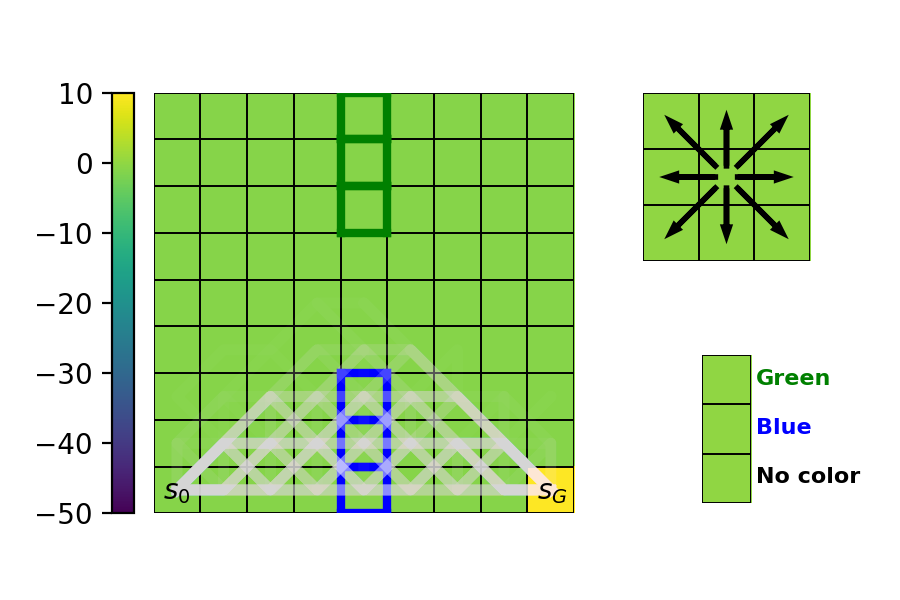

In [6]:
blue = [4, 13, 22]  # blue states
green = [58, 67, 76]  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

## Constrained world

<IPython.core.display.Javascript object>


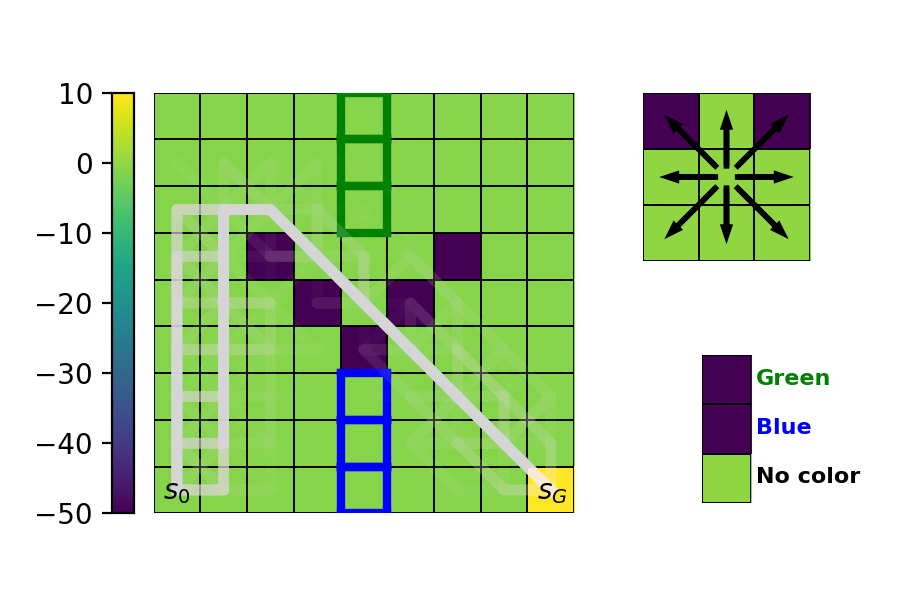

In [7]:
cs = [31, 39, 41, 47, 51]  # constrained states
ca = [Directions.UP_LEFT, Directions.UP_RIGHT]  # constrained actions
cc = [1, 2]  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

## Learn constraints

In [8]:
print(Directions.UP_LEFT.idx)

4


In [9]:
learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories)

         1: DELTA:  0.00000, MAE:  0.496315288889989
       101: DELTA:  0.31305, MAE:  0.175528270309275
       201: DELTA:  0.22181, MAE:  0.053586313269923
       301: DELTA:  0.14176, MAE:  0.030193682221069
       401: DELTA:  0.17469, MAE:  0.028076117528057


IcyGridWorld(size=9, p_slip=0.1)
-22.59
0.795


<IPython.core.display.Javascript object>


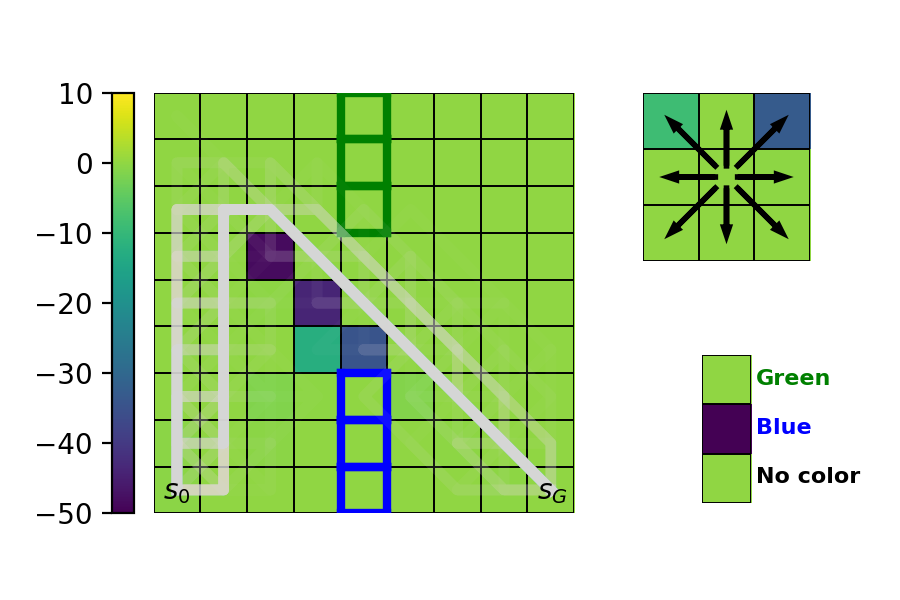

In [21]:
learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)

def total_reward(trajectory, grid):
    reward = 0
    count_cs = 0
    count_ca = 0
    count_cc = 0
    for state in trajectory.transitions():
        #check for action constraints violation
        reward += grid.reward[state]
        for constraint in ca:
            if (state[1] == constraint.idx): 
                count_ca += 1
                
        #check for color constraints violation        
        for constraint in cc:
            if (state[0] == constraint): 
                count_cc += 1
                
        #check for state constraints violation
        for constraint in cs:
            if (state[0] == constraint): 
                count_cs += 1
                
    return reward, count_cs, count_ca, count_cc
        

# calculate the kl divergence
def kl_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    return sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p)))
    
# calculate the js divergence
def js_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

#count how many times a state is visited, and compute the average length of the trajectories
def count_states(trajectories, grid):
    count_matrix = np.ones((8,9,9)) * 1e-10
    avg_length = 0.0
    avg_reward = 0.0
    avg_violated = 0.0
    n = len(trajectories)
    for trajectory in trajectories:
        avg_length += len(trajectory.transitions())
        #print(trajectory)
        #print(list(trajectory.transitions()))
        reward, count_cs, count_ca, count_cc = total_reward(trajectory, grid)
        avg_reward += reward
        avg_violated += (count_cs + count_ca + count_cc)
        for state in trajectory.states():
            #print(state)
            count_matrix[0][grid.world.state_index_to_point(state)] += 1
            
    return count_matrix / n, avg_length / n, avg_reward / n, avg_violated / n

print(c.world)
rl_matrix, avg_rl, avg_reward, avg_violated = count_states(demo_l[0], c)
print(avg_reward)
print(avg_violated)
    
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

## MDFT as orchestrator

<IPython.core.display.Javascript object>


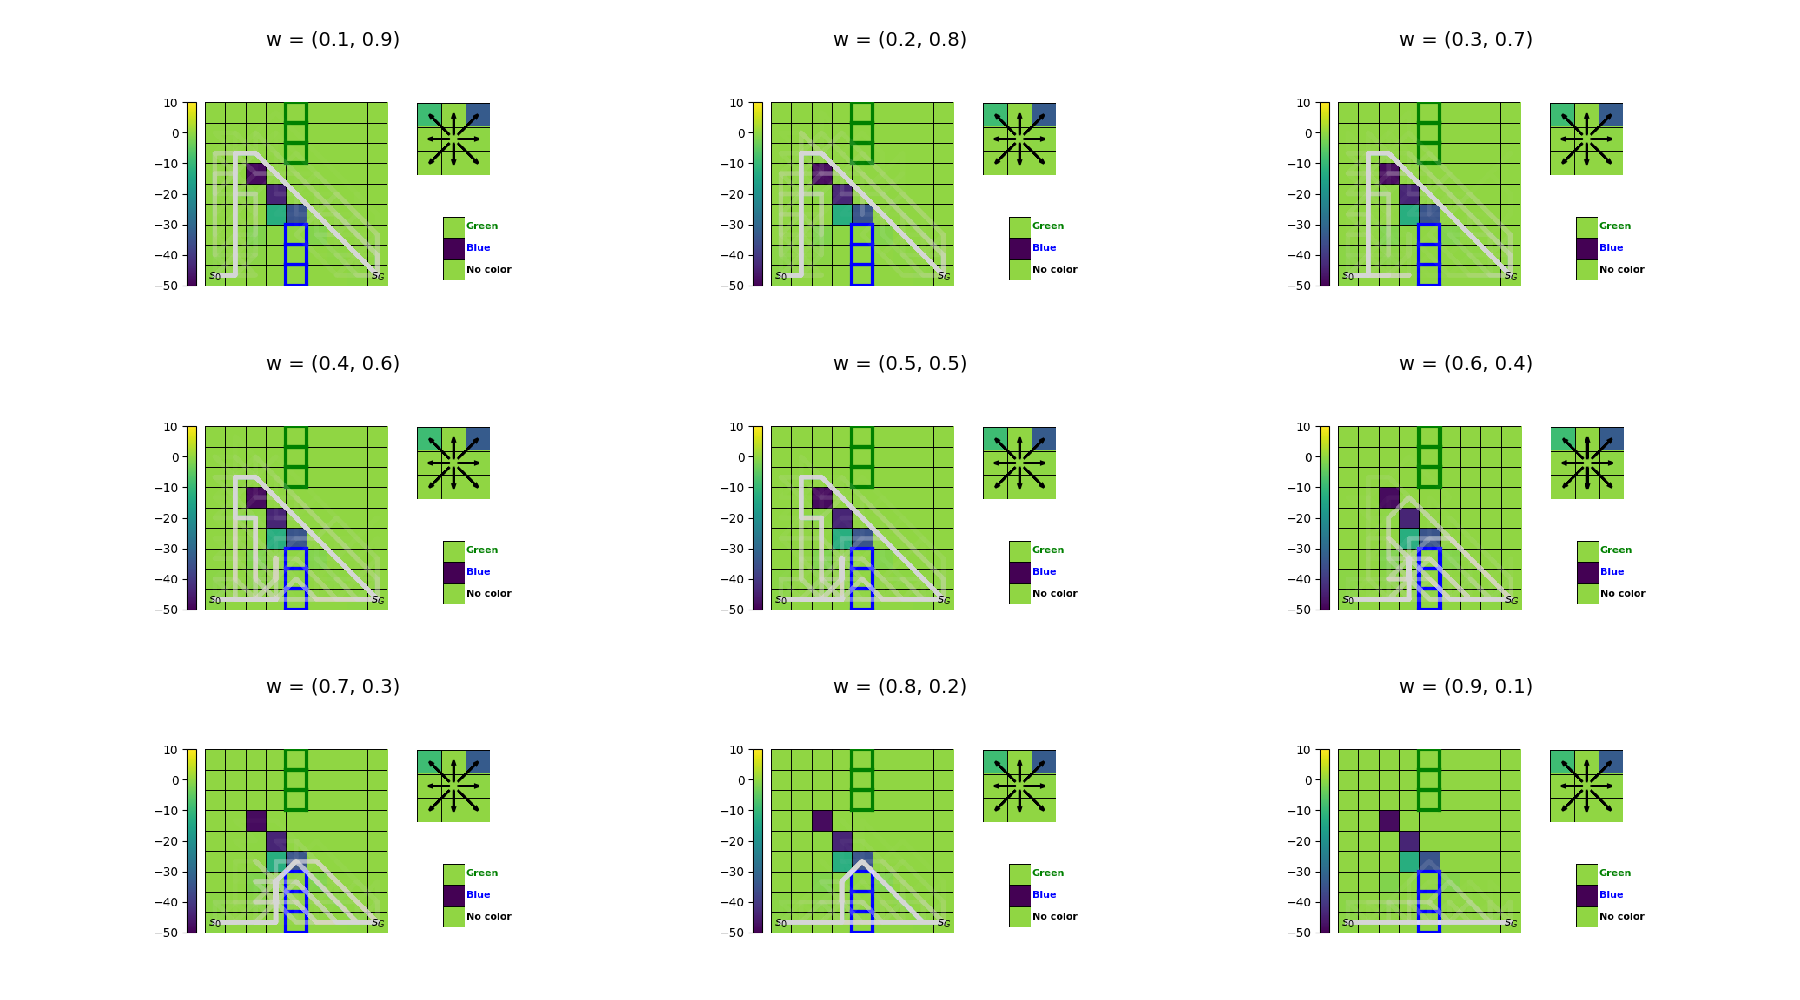

Average Length RL: 16.93 	 Reward: -22.59 	 # of violated const.: 0.795

Average Length MDFT: 16.455 	 Reward: -17.46 	 # of violated const.: 1.37
KL(RL||MDFT) [6.56351885] 	 KL(MDFT||RL) [3.47866301]
JS(RL||MDFT) [1.04120537] 	 JS DISTANCE [0.20192988]

Average Length MDFT: 16.185 	 Reward: -24.54 	 # of violated const.: 1.43
KL(RL||MDFT) [8.80591423] 	 KL(MDFT||RL) [3.69274143]
JS(RL||MDFT) [1.18162008] 	 JS DISTANCE [0.21581642]

Average Length MDFT: 18.405 	 Reward: -23.33 	 # of violated const.: 2.905
KL(RL||MDFT) [11.59774395] 	 KL(MDFT||RL) [46.22987556]
JS(RL||MDFT) [2.64023473] 	 JS DISTANCE [0.31216219]

Average Length MDFT: 36.63 	 Reward: -55.275 	 # of violated const.: 11.93
KL(RL||MDFT) [22.37250886] 	 KL(MDFT||RL) [641.94185041]
JS(RL||MDFT) [14.60179223] 	 JS DISTANCE [0.59704082]

Average Length MDFT: 38.57 	 Reward: -63.59 	 # of violated const.: 12.2
KL(RL||MDFT) [53.52295576] 	 KL(MDFT||RL) [740.47782926]
JS(RL||MDFT) [17.00653307] 	 JS DISTANCE [0.63599827]

Averag

In [22]:
fig = plt.figure(figsize=(9, 5))
axis = fig.subplots(3, 3)
print(f"Average Length RL: {avg_rl} \t Reward: {avg_reward} \t # of violated const.: {avg_violated}\n")
for i in range(9):
    w = [(i+1)/10, 1 - (i+1)/10]
    demo_mdft = G.generate_mdft_trajectories(n.world, n.reward, learned_params.reward, n.start, n.terminal, w)
    #print(len(demo_mdft))
    mdft_matrix, avg_mdft, avg_reward, avg_violated = count_states(demo_mdft[0], c)
    #print(mdft_matrix[0])
    p = np.reshape(rl_matrix[0], (-1,1))
    q = np.reshape(mdft_matrix[0], (-1,1))
    print(f"Average Length MDFT: {avg_mdft} \t Reward: {avg_reward} \t # of violated const.: {avg_violated}")
    print(f"KL(RL||MDFT) {kl_divergence(rl_matrix[0], mdft_matrix[0])} \t KL(MDFT||RL) {kl_divergence(mdft_matrix[0], rl_matrix[0])}")
    print(f"JS(RL||MDFT) {js_divergence(rl_matrix[0], mdft_matrix[0])} \t JS DISTANCE {distance.jensenshannon(p,q)}\n")
    
    plt.ioff()
    f1 = G.plot_world(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                  learned_params.action_weights, learned_params.color_weights, 
                  demo_mdft, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    plt.close()
    plt.ion()
    canvas = FigureCanvas(f1)
    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())
    
    x = i // 3
    y = i % 3
    axis[x,y].axis('off')   
    axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=7)
    axis[x,y].imshow(X)
    
    
fig.tight_layout()